In [1]:
from nldg.utils import *
from scipy.interpolate import BSpline

In [2]:
data_setting = 2
if data_setting == 1:
    dtr = gen_data_v2(n=1000)
elif data_setting == 2:
    dtr = gen_data_v3(n=1000, setting=2)
elif data_setting == 3:
    dtr = gen_data_v4(n_easy=1000, n_hard=1000)
elif data_setting == 4:
    dtr = gen_data_v5(n_samples=1000, adv_fraction=0.5, noise_var_env2=10.0)
else:
    dtr = gen_data_v6(n=1000, noise_std=0.5)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)

In [3]:
from scipy.interpolate import make_smoothing_spline

idx = np.argsort(Xtr.flatten())
Xs = Xtr[idx].flatten()
Ys = Ytr[idx].flatten()
spline = make_smoothing_spline(Xs, Ys, lam=10)
x_grid = np.linspace(min(Xtr), max(Xtr), 200)

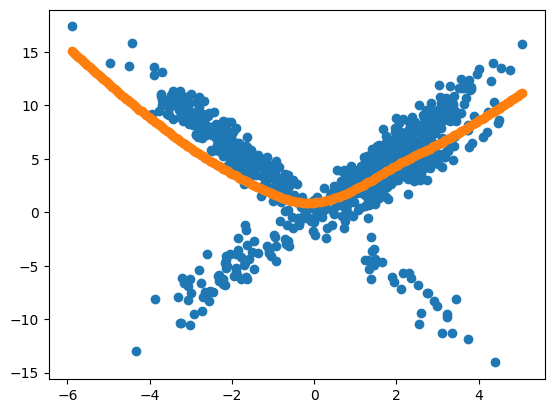

In [4]:
plt.scatter(Xtr, Ytr)
plt.scatter(x_grid, spline(x_grid))

In [5]:
def _coeff_of_divided_diff(x):
    n = x.shape[0]
    res = np.zeros(n)
    for i in range(n):
        pp = 1.
        for k in range(n):
            if k != i:
                pp *= (x[i] - x[k])
        res[i] = 1. / pp
    return res

In [6]:
idx = np.argsort(Xtr.flatten())
x = Xtr[idx].flatten()
y = Ytr[idx].flatten()
e_tr = Etr[idx].flatten()
t = np.r_[[x[0]] * 3, x, [x[-1]] * 3]
n = x.shape[0]

X_bspl = BSpline.design_matrix(x, t, 3)

# move from B-spline basis to the basis of natural splines using equations
# (2.1.7) [4]
# central elements
X = np.zeros((5, n))
for i in range(1, 4):
    X[i, 2: -2] = X_bspl[i: i - 4, 3: -3][np.diag_indices(n - 4)]

# first elements
X[1, 1] = X_bspl[0, 0]
X[2, :2] = ((x[2] + x[1] - 2 * x[0]) * X_bspl[0, 0],
            X_bspl[1, 1] + X_bspl[1, 2])
X[3, :2] = ((x[2] - x[0]) * X_bspl[1, 1], X_bspl[2, 2])

# last elements
X[1, -2:] = (X_bspl[-3, -3], (x[-1] - x[-3]) * X_bspl[-2, -2])
X[2, -2:] = (X_bspl[-2, -3] + X_bspl[-2, -2],
             (2 * x[-1] - x[-2] - x[-3]) * X_bspl[-1, -1])
X[3, -2] = X_bspl[-1, -1]

# create penalty matrix and divide it by vector of weights: W^{-1} E
E = np.zeros((5, n))
E[2:, 0] = _coeff_of_divided_diff(x[:3])
E[1:, 1] = _coeff_of_divided_diff(x[:4])
for j in range(2, n - 2):
    E[:, j] = (x[j+2] - x[j-2]) * _coeff_of_divided_diff(x[j-2:j+3])

E[:-1, -2] = -_coeff_of_divided_diff(x[-4:])
E[:-2, -1] = _coeff_of_divided_diff(x[-3:])
E *= 6

In [7]:
import scipy
c_erm = scipy.linalg.solve_banded((2, 2), X + 10 * E, y)
# move back to B-spline basis using equations (2.2.10) [4]
c_ = np.r_[c_erm[0] * (t[5] + t[4] - 2 * t[3]) + c_erm[1],
           c_erm[0] * (t[5] - t[3]) + c_erm[1],
           c_erm[1: -1],
           c_erm[-1] * (t[-4] - t[-6]) + c_erm[-2],
           c_erm[-1] * (2 * t[-4] - t[-5] - t[-6]) + c_erm[-2]]

In [8]:
n = E.shape[1]
l = u = 2
E_full = np.zeros((n, n))
for j in range(n):
    for d in range(-u, l+1):
        i = j + d
        if 0 <= i < n:
            k = u + d
            E_full[i, j] = E[k, j]

In [9]:
n = X.shape[1]
l = u = 2
X_full = np.zeros((n, n))
for j in range(n):
    for d in range(-u, l+1):
        i = j + d
        if 0 <= i < n:
            k = u + d
            X_full[i, j] = X[k, j]

In [ ]:
# import cvxpy as cp
#
#
# lam = 10
# c = cp.Variable(n)
# t_var = cp.Variable(nonneg=True)
#
# mask_0 = e_tr == 0
# mask_1 = e_tr == 1
# mask_2 = e_tr == 2
#
# n0, n1, n2 = np.sum(mask_0), np.sum(mask_1), np.sum(mask_2)
#
# x_0 = X_full[mask_0,:]
# x_1 = X_full[mask_1,:]
# x_2 = X_full[mask_2,:]
#
# y_0 = y[mask_0]
# y_1 = y[mask_1]
# y_2 = y[mask_2]
#
# constraints = []
# constraints.append(cp.norm(x_0 @ c - y_0, 2)**2 / n0 <= t_var)
# constraints.append(cp.norm(x_1 @ c - y_1, 2)**2 / n1 <= t_var)
# constraints.append(cp.norm(x_2 @ c - y_2, 2)**2 / n2 <= t_var)
#
# K = X_full.T @ E_full
# K = 0.5*(K + K.T)
# eigvals, Q = np.linalg.eigh(K)
# eigvals[eigvals < 0] = 0
# K_psd = (Q * eigvals) @ Q.T
# K_psd = 0.5*(K_psd + K_psd.T)
# K_trusted = cp.psd_wrap(K_psd)
# roughness = cp.quad_form(c, K_psd)
# objective = cp.Minimize(t_var + lam * roughness)
#
# prob = cp.Problem(objective)
# prob.solve(solver=cp.MOSEK)
#
# c_opt = c.value

In [11]:
# c_ = np.r_[c_opt[0] * (t[5] + t[4] - 2 * t[3]) + c_opt[1],
#            c_opt[0] * (t[5] - t[3]) + c_opt[1],
#            c_opt[1: -1],
#            c_opt[-1] * (t[-4] - t[-6]) + c_opt[-2],
#            c_opt[-1] * (2 * t[-4] - t[-5] - t[-6]) + c_opt[-2]]
#
# spline_minmax = BSpline.construct_fast(t, c_, 3)

In [10]:
# preds_erm = spline(x_grid)
# preds_cvxpy = spline_minmax(x_grid)
#
# plot_dtr(dtr, x_grid, preds_erm, preds_cvxpy)

In [11]:
K = X_full.T @ E_full
kappa = np.linalg.svd(K, compute_uv=False)[0]

In [426]:
import numpy as np

def project_onto_simplex(v: np.ndarray) -> np.ndarray:
    original_shape = v.shape

    v_flat = v.reshape(-1)
    D = v_flat.shape[0]

    # Step 1: Sort v in descending order
    u = np.sort(v_flat)[::-1]

    # Step 2: Find ρ (rho)
    cumsum = np.cumsum(u)
    j_range = np.arange(1, D + 1, dtype=float)

    # Calculate the term: u_j + (1/j) * (1 - sum(u_i from i=1 to j))
    term = u + (1 / j_range) * (1 - cumsum)

    # Find the largest j such that term[j-1] > 0
    rho = np.sum(term > 0)

    # If rho is 0, that's a special case - return zeros
    if rho == 0:
        return np.zeros_like(v)

    # Step 3: Compute λ (lambda)
    lambda_val = (1 / rho) * (1 - np.sum(u[:rho]))

    # Step 4: Compute the projection
    x = np.maximum(v_flat + lambda_val, 0)

    # Ensure the output sums to 1 (handle numerical precision issues)
    x = x / np.sum(x)

    # Reshape back to the original shape
    return x.reshape(original_shape)

def train_spline_extragradient(
    X_full: np.ndarray,
    Y: np.ndarray,
    E_full: np.ndarray,
    E: np.ndarray,
    init = np.ndarray,
    alpha_loss: float = 1e-3,
    alpha_reg: float = 1e-3,
    lam: float = 0.01,
    epochs: int = 500,
    seed: int = 0,
    verbose: bool = False,
):
    np.random.seed(seed)

    envs, inv = np.unique(E, return_inverse=True)
    num_env = len(envs)
    n = len(Y)

    K = X_full.T @ E_full

    #c = np.zeros(n, dtype=np.float32)
    c = init
    p = np.ones(num_env, dtype=np.float32) / num_env

    def compute_losses_and_grad(c_vec: np.ndarray, p_vec: np.ndarray):
        losses = []
        grad_loss = np.zeros_like(c_vec)
        for e in range(num_env):
            idx = np.where(inv == e)[0]
            if len(idx) == 0:
                losses.append(0.0)
                continue
            y_e = Y[idx]
            X_full_e = X_full[idx, :]

            pred_e = X_full_e @ c_vec
            resid = pred_e - y_e
            loss_e = np.mean(resid**2)
            losses.append(loss_e)

            # gradient w.r.t c: (2/n_e) * X_full_e.T @ (pred_e - y_e)
            grad_e = (2.0 / len(idx)) * X_full_e.T @ resid
            grad_loss += p_vec[e] * grad_e

        losses = np.array(losses)
        # add reg grad
        grad_reg = 2 * lam * (K @ c_vec)
        return losses, grad_loss, grad_reg

    # extragradient loop
    for t in range(epochs):
        # step 1: compute at current (c, p)
        losses, grad_loss, grad_reg = compute_losses_and_grad(c, p)
        c_half = c - alpha_loss * grad_loss - alpha_reg * grad_reg
        p_half = project_onto_simplex(p + alpha_loss * losses)

        # step 2: compute at (c_half, p_half)
        losses_h, grad_loss_h, grad_loss_reg = compute_losses_and_grad(c_half, p_half)
        c = c - alpha_loss * grad_loss_h - alpha_reg * grad_loss_reg
        p = project_onto_simplex(p + alpha_loss * losses_h)

        #print('.........................')
        #print(p_half, losses)
        #print(p, losses_h)
        #losses_new, _, _ = compute_losses_and_grad(c, p)
        #print(losses_new)
        #obj = np.sum(p * losses_new) + lam * (c.T @ (K @ c))
        #print(obj)

        if verbose and (t % max(1, epochs // 10) == 0):
            losses_new, _, _ = compute_losses_and_grad(c, p)
            obj = np.sum(p * losses_new) + lam * (c.T @ (K @ c))
            print(f"Iter {t}/{epochs}: obj={obj:.6f}")

    return c, p

In [444]:
c, p = train_spline_extragradient(X_full, y, E_full, e_tr, init=c_erm,
                                  alpha_loss=0.1, alpha_reg=0.01/kappa, lam=10, epochs=500, verbose=True)

Iter 0/500: obj=2107422.962845
Iter 50/500: obj=4936324865.468598
Iter 100/500: obj=18612776827.768475
Iter 150/500: obj=39824326417.908524
Iter 200/500: obj=67511707322.821823
Iter 250/500: obj=88997300102.797638
Iter 300/500: obj=99716703789.614166
Iter 350/500: obj=128239823292.718430
Iter 400/500: obj=159256384724.643402
Iter 450/500: obj=183248929084.398346


In [457]:
import torch
import torch.nn.functional as F

def train_spline_GDRO(
    X_full: np.ndarray,
    Y: np.ndarray,
    E_full: np.ndarray,
    E: np.ndarray,
    init: np.ndarray,
    lr: float = 1e-3,
    eta: float = 0.1,
    lam: float = 0.01,
    epochs: int = 500,
    seed: int = 0,
    verbose: bool = False,
):
    torch.manual_seed(seed)

    # convert data to torch tensors
    X = torch.from_numpy(X_full).float()
    y = torch.from_numpy(Y).float()
    E_tensor = torch.from_numpy(E_full).float()
    env_labels = torch.from_numpy(E).long()
    num_env = torch.unique(env_labels).numel()

    # penalty matrix
    K = X.t() @ E_tensor

    # initialize c (requires_grad=True for Adam) and optimizer
    c = torch.from_numpy(init).float()
    c = torch.nn.Parameter(c)
    optimizer = torch.optim.Adam([c], lr=lr)

    # initialize p on simplex
    p = torch.ones(num_env) / num_env

    for t in range(1, epochs+1):
        # compute per-env MSE losses
        losses = []
        for e in range(num_env):
            idx = (env_labels == e).nonzero(as_tuple=True)[0]
            if idx.numel() == 0:
                losses.append(torch.tensor(0.0))
                continue
            X_e = X[idx]
            y_e = y[idx]
            pred = X_e @ c
            loss_e = F.mse_loss(pred, y_e, reduction='mean')
            losses.append(loss_e)
        losses = torch.stack(losses)

        # mirror-ascent update on p using same lr
        with torch.no_grad():
            p = p * torch.exp(eta * losses)
            p = p / p.sum()

        # weighted loss and penalty
        weighted_loss = torch.dot(p, losses)
        reg = lam * (c.T @ (K @ c))
        obj = weighted_loss + reg

        # descent on loss+reg via Adam
        optimizer.zero_grad()
        obj.backward()
        optimizer.step()

        if verbose and t % (epochs // 10 or 1) == 0:
            print(f"Epoch {t}/{epochs}: obj={obj.item():.6f}")

    return c.detach().cpu().numpy(), p.detach().cpu().numpy()


In [472]:
c, p = train_spline_GDRO(X_full, y, E_full, e_tr, init=c_erm,
                         lr=1, lam=100, epochs=1000, verbose=True)

Epoch 100/1000: obj=37153021952.000000
Epoch 200/1000: obj=3602907904.000000
Epoch 300/1000: obj=2859280896.000000
Epoch 400/1000: obj=1959308800.000000
Epoch 500/1000: obj=2644780800.000000
Epoch 600/1000: obj=1883656832.000000
Epoch 700/1000: obj=5169874944.000000
Epoch 800/1000: obj=3347454464.000000
Epoch 900/1000: obj=6338396672.000000
Epoch 1000/1000: obj=10264448000.000000


In [473]:
c_ = np.r_[c[0] * (t[5] + t[4] - 2 * t[3]) + c[1],
           c[0] * (t[5] - t[3]) + c[1],
           c[1: -1],
           c[-1] * (t[-4] - t[-6]) + c[-2],
           c[-1] * (2 * t[-4] - t[-5] - t[-6]) + c[-2]]

In [474]:
spline_minmax = BSpline.construct_fast(t, c_, 3)

In [466]:
def plot_dtr(dtr, x_grid, preds_erm, preds_maximin, preds_magging=None, optfun=None,
             saveplot=False, nameplot='setting5'):
    line_colors = ["lightskyblue", "orange", "mediumpurple"]
    data_colors = ["black", "grey", "silver"]
    environments = sorted(dtr["E"].unique())

    fig, ax = plt.subplots(figsize=(8, 5))
    for idx, env in enumerate(environments):
        marker_style = "o"
        ax.scatter(
            dtr[dtr["E"] == env]["X"],
            dtr[dtr["E"] == env]["Y"],
            color=data_colors[idx],
            marker=marker_style,
            alpha=0.5,
            s=30,
            label=f"Env {env + 1}",
        )

    ax.plot(x_grid, preds_erm, color=line_colors[0], linewidth=2, label="SS")
    ax.plot(
        x_grid,
        preds_maximin,
        color=line_colors[1],
        linewidth=2,
        label="MaximinSS",
    )
    if preds_magging is not None:
        ax.plot(
            x_grid,
            preds_magging,
            color=line_colors[2],
            linewidth=2,
            label="MaggingSS",
        )

    if optfun == 1:
        y_opt = 0.8 * np.sin(x_grid / 2) ** 2 + 3
        ax.plot(x_grid, y_opt, color="orangered", linewidth=2, linestyle="--", label="Optimal")
    elif optfun == 2:
        y_opt = np.where(x_grid > 0, 2.4 * x_grid, -2.4 * x_grid)
        ax.plot(x_grid, y_opt, color="orangered", linewidth=2, linestyle="--", label="Optimal")
    elif optfun == 3:
        y_opt = np.where(x_grid > 0, 1.86 * x_grid, 1.63 * x_grid)
        ax.plot(x_grid, y_opt, color="orangered", linewidth=2, linestyle="--", label="Optimal")

    ax.set_xlabel("$X$")
    ax.set_ylabel("$Y$")
    ax.grid(True, linewidth=0.2)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, loc="upper left")

    plt.tight_layout()
    if saveplot:
        plt.savefig(f"{nameplot}.png", dpi=300, bbox_inches="tight")
    plt.show()

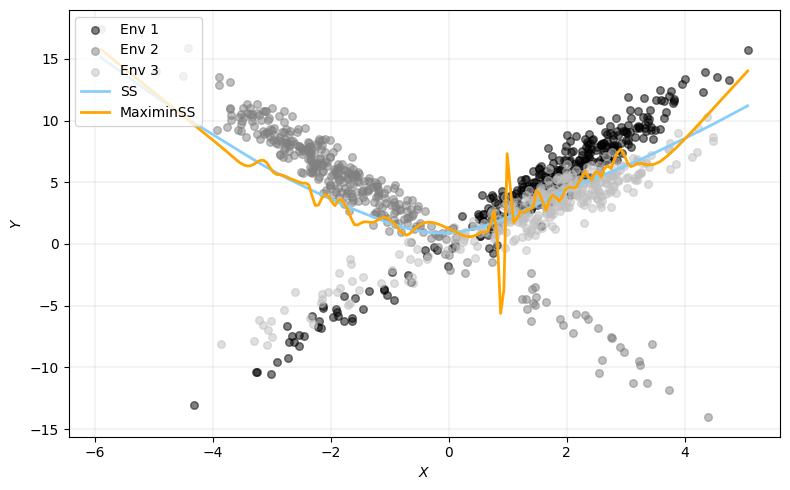

In [475]:
preds_erm = spline(x_grid)
preds_gdro = spline_minmax(x_grid)

plot_dtr(dtr, x_grid, preds_erm, preds_gdro)

## IML

In [22]:
import numpy as np
from scipy.special import factorial

x1 = np.array([1, 2])
x2 = np.array([3, 4])
x3 = np.array([3, 4, 4])
x4 = np.array([1, 1])

pi1, pi2 = 0.5, 0.5
l1, l2 = 1.5, 3.5

gamma_11 = ((pi1 * np.prod(np.exp(-l1) * (l1**x1) / factorial(x1))) /
            (pi1 * np.prod(np.exp(-l1) * (l1**x1) / factorial(x1)) +
             pi2 * np.prod(np.exp(-l2) * (l2**x1) / factorial(x1))))
gamma_12 = 1-gamma_11
gamma_11, gamma_12

(np.float64(0.8112428856213154), np.float64(0.1887571143786846))

In [23]:
gamma_21 = ((pi1 * np.prod(np.exp(-l1) * (l1**x2) / factorial(x2))) /
            (pi1 * np.prod(np.exp(-l1) * (l1**x2) / factorial(x2)) +
             pi2 * np.prod(np.exp(-l2) * (l2**x2) / factorial(x2))))
gamma_22 = 1-gamma_21
gamma_21, gamma_22

(np.float64(0.12663053315277262), np.float64(0.8733694668472274))

In [25]:
gamma_31 = ((pi1 * np.prod(np.exp(-l1) * (l1**x3) / factorial(x3))) /
            (pi1 * np.prod(np.exp(-l1) * (l1**x3) / factorial(x3)) +
             pi2 * np.prod(np.exp(-l2) * (l2**x3) / factorial(x3))))
gamma_32 = 1-gamma_31
gamma_31, gamma_32

(np.float64(0.03488210007178075), np.float64(0.9651178999282193))

In [26]:
gamma_41 = ((pi1 * np.prod(np.exp(-l1) * (l1**x4) / factorial(x4))) /
            (pi1 * np.prod(np.exp(-l1) * (l1**x4) / factorial(x4)) +
             pi2 * np.prod(np.exp(-l2) * (l2**x4) / factorial(x4))))
gamma_42 = 1-gamma_41
gamma_41, gamma_42

(np.float64(0.9093236311352831), np.float64(0.09067636886471686))

In [27]:
x_12 = gamma_11 * l1 + gamma_12 * l2
x_12

np.float64(1.8775142287573692)

In [28]:
x_23 = gamma_21 * l1 + gamma_22 * l2
x_23

np.float64(3.2467389336944548)

In [29]:
x_41 = gamma_41 * l1 + gamma_42 * l2
x_41

np.float64(1.6813527377294337)

In [30]:
(gamma_11 + gamma_21 + gamma_31 + gamma_41) / 4

np.float64(0.470519787495288)

In [31]:
(gamma_12 + gamma_22 + gamma_32 + gamma_42) / 4

np.float64(0.529480212504712)

In [32]:
((gamma_11 * (np.sum(x1) + x_12) + gamma_21 * (np.sum(x2) + x_23) + gamma_31 * np.sum(x3) + gamma_41 * (np.sum(x4) + x_41))
 / (3 * (gamma_11 + gamma_21 + gamma_31 + gamma_41)))

np.float64(1.591439069160769)

In [33]:
((gamma_12 * (np.sum(x1) + x_12) + gamma_22 * (np.sum(x2) + x_23) + gamma_32 * np.sum(x3) + gamma_42 * (np.sum(x4) + x_41))
 / (3 * (gamma_12 + gamma_22 + gamma_32 + gamma_42)))

np.float64(3.276792745173848)

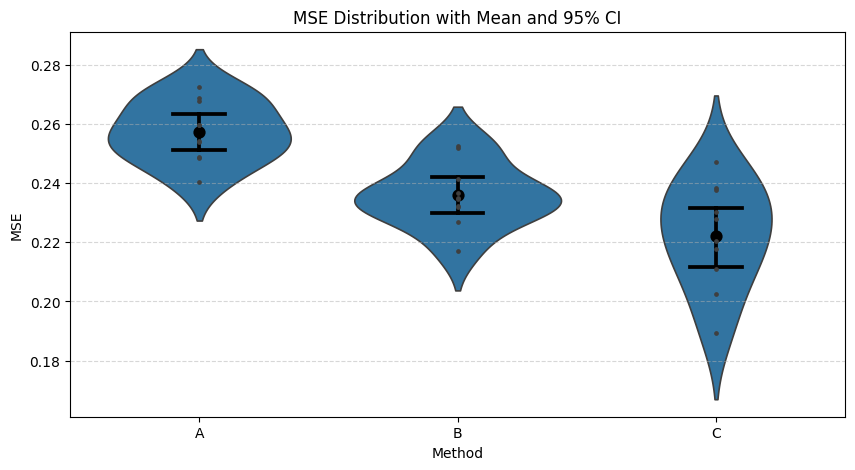

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example data
np.random.seed(0)
data = {
    'Method': ['A'] * 10 + ['B'] * 10 + ['C'] * 10,
    'MSE': np.concatenate([
        np.random.normal(0.25, 0.01, 10),
        np.random.normal(0.23, 0.015, 10),
        np.random.normal(0.22, 0.012, 10)
    ])
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
sns.violinplot(x='Method', y='MSE', data=df, inner='point', linewidth=1.2)
sns.pointplot(
    x='Method', y='MSE', data=df, color='black',
    errorbar=('ci', 95),  # updated ci parameter
    linestyle='none',     # updated join parameter
    capsize=0.2
)
plt.title('MSE Distribution with Mean and 95% CI')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()
